In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch

from text_clustering import TextClustering
from utils.training_and_visualisation import plot_losses

import umap.umap_ as umap

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

C:\Users\Emil\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Emil\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Emil\AppData\Local\Programs\Python\Python39\lib

cuda


In [2]:
data_all = pd.read_csv("../sber_data/demo.csv")

In [3]:
mask = data_all['category'] != 'Другое'

In [4]:
data = data_all[mask].reset_index()

In [5]:
cluster_mapping = dict(zip(list(data['category'].unique()), list(range(data['category'].nunique()))))

In [6]:
data['cluster'] = data['category'].map(cluster_mapping)

In [7]:
df1 = pd.read_parquet('../sber_data/demo_embedings1.parquet', engine='fastparquet')
df2 = pd.read_parquet('../sber_data/demo_embedings2.parquet', engine='fastparquet')
df3 = pd.read_parquet('../sber_data/demo_embedings3.parquet', engine='fastparquet')

embeds_all = pd.concat([df1, df2, df3], ignore_index=True)
assert (embeds_all['dialogue_id'] == data_all['dialogue_id']).all()

In [8]:
embeds = embeds_all[mask].reset_index().drop(columns=['index', 'dialogue_id'])

In [9]:
embeds = torch.Tensor(embeds.to_numpy())

In [10]:
def sample_clusters(dataframe, raw_embeds, cluster_num_list, noise_cluster_num_list, noise_frac=0.):
    target_idxs = dataframe[dataframe["cluster"].isin(cluster_num_list)].index.to_list()
    target_size = len(target_idxs)
    #print(target_idxs)
    target_data = dataframe.loc[target_idxs]
    target_embeds = raw_embeds[target_idxs]
    target_clusters = target_data["cluster"].to_list()
                
    if noise_frac != 0. and noise_cluster_num_list is not None:
        non_target_idxs = dataframe[dataframe["cluster"].isin(noise_cluster_num_list)].index.to_list()
        noise_data_all = dataframe.loc[non_target_idxs]

        noise_num = int(noise_frac * target_size)
        noise_idxs = list(np.random.choice(non_target_idxs, noise_num, replace=False))
        noise_data = dataframe.loc[noise_idxs]
        noise_embeds = raw_embeds[noise_idxs]
        noise_clusters = noise_data["cluster"].to_list()
        subset_data = pd.concat((target_data, noise_data))
        subset_clusters = target_clusters + noise_clusters
        subset_embeds = torch.vstack((target_embeds, noise_embeds))
        subset_idxs = target_idxs + noise_idxs
     
        return subset_embeds, subset_idxs, subset_data, subset_clusters, target_idxs
    
    return target_embeds, target_idxs, target_data, target_clusters, target_idxs


base_embeds, base_idxs, base_data, base_clusters, base_idxs_pure = sample_clusters(
    dataframe=data,
    raw_embeds=embeds,
    cluster_num_list=[0, 1, 2, 3],
    noise_cluster_num_list=None,
    noise_frac=0
)

In [11]:
base_embeds

tensor([[ 0.6311, -0.3407,  1.0543,  ...,  0.0079,  0.8581,  1.4107],
        [-0.2384, -0.6460, -0.3904,  ..., -0.3667,  0.3252,  0.3188],
        [ 1.9864, -0.2911,  0.0683,  ..., -0.4676,  0.0814, -0.1282],
        ...,
        [ 0.5705,  0.1035, -1.8601,  ...,  0.8367, -1.3492, -0.4995],
        [ 0.5213,  0.1594, -1.3816,  ...,  0.3226, -0.6026, -0.2743],
        [-0.8528, -0.2300,  0.3042,  ..., -0.6538,  0.6528,  0.3272]])

In [12]:
n_classes = 4
inp_dim = 1536
feat_dim = 10
model = TextClustering(n_classes, inp_dim, feat_dim, base_embeds)

In [ ]:
losses1, losses2 = model.fit(base_embeds)

In [15]:
torch.save(model.state_dict(), "./checkpoints/checkpoint_1.torch")

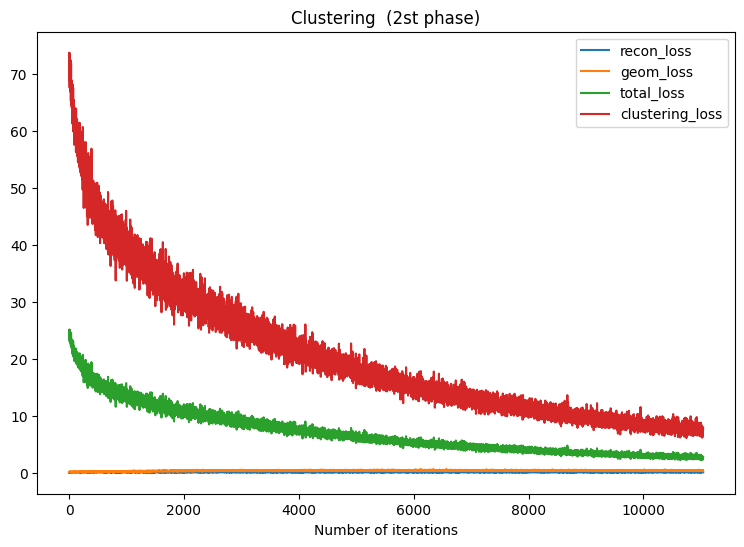

In [16]:
plot_losses(losses2, "Clustering  (2st phase)")

In [13]:
model.load_state_dict(torch.load("./checkpoints/checkpoint_1.torch"))
model.model.mode = "train_clusters"
model.model.mode

'train_clusters'

In [14]:
dec_features, pred_clusters = model.transform_and_cluster(base_embeds)
dim_reduction = umap.UMAP(random_state=42, n_components=2)
umap_features = dim_reduction.fit_transform(dec_features)

In [16]:
model.kind

'deep clustering'

In [ ]:
topics = model.get_topics(base_data['text'].to_list(), base_embeds, lang='russian')

No sentence-transformers model found with name C:\Users\Emil/.cache\torch\sentence_transformers\ai-forever_ruBert-base. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\Emil/.cache\torch\sentence_transformers\ai-forever_ruBert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initial

In [ ]:
topics

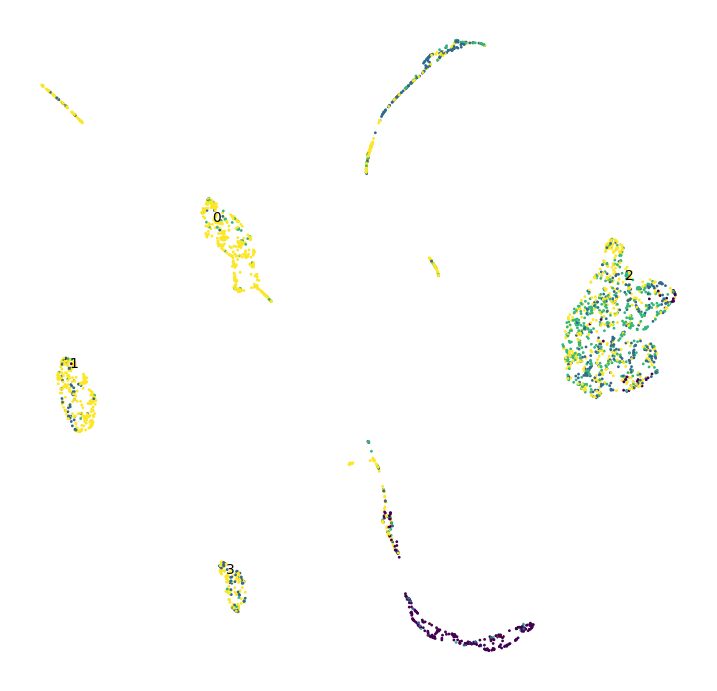

In [21]:
#umap_embeds = model.transform(base_embeds.to(device), batch_size=128)
new_centers = dim_reduction.transform(model.get_centers())
_, pred_clusters = model.transform_and_cluster(base_embeds.to(device))
plt.figure(figsize=(9, 9))
plt.scatter(*umap_features.T, c=base_clusters, s=1.0)
#plt.scatter(*new_umap_embeds.T, c=base_clusters, s=1.0)

for i, (x, y) in enumerate(new_centers):
    #plt.text(x, y, "\n".join(topics[i]), 
    #         horizontalalignment='center', 
    #         verticalalignment='center', 
    #         fontsize=12) # backgroundcolor='white')
    plt.text(x, y, str(i))

plt.gca().set_aspect("equal")
plt.axis("off")
#plt.title("Parametric UMAP for Banking77")
#plt.legend()
plt.show()

In [14]:
new_centers

NameError: name 'new_centers' is not defined

In [14]:
base_embeds, base_idxs, base_data, base_clusters, base_idxs_pure = sample_clusters(
    dataframe=data_all,
    raw_embeds=embeds_t5_all,
    cluster_num_list=[1, 4, 6],
    noise_cluster_num_list=None,
    noise_frac=0
)

In [15]:
n_classes = 3
inp_dim = 1024
feat_dim = 10
model = TextClustering(n_classes, inp_dim, feat_dim, base_embeds)
losses1, losses2 = model.fit(base_embeds)

Phase 1: train embeddings


  0%|          | 0/20 [00:00<?, ?it/s]

Phase 2: train clusters


  0%|          | 0/8 [00:00<?, ?it/s]

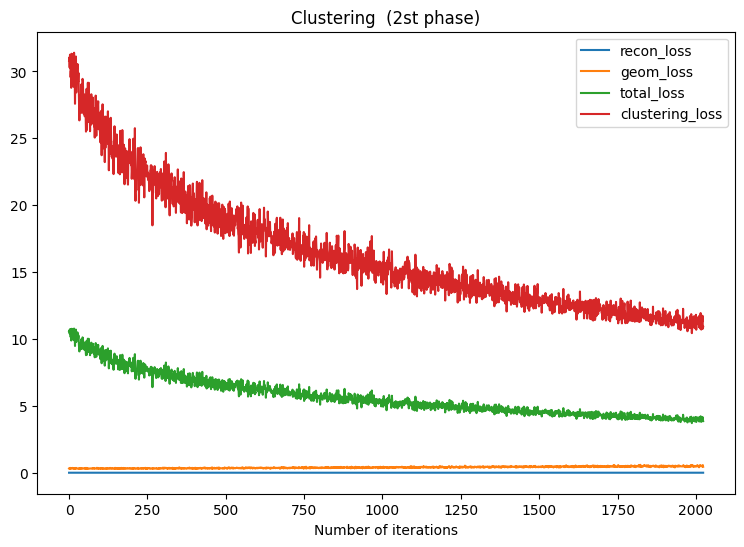

In [16]:
plot_losses(losses2, "Clustering  (2st phase)")

In [17]:
dec_features, pred_clusters = model.transform_and_cluster(base_embeds)
dim_reduction = umap.UMAP(random_state=42, n_components=2)
umap_features = dim_reduction.fit_transform(dec_features)
topics = model.get_topics(base_data['text'].to_list(), base_embeds)

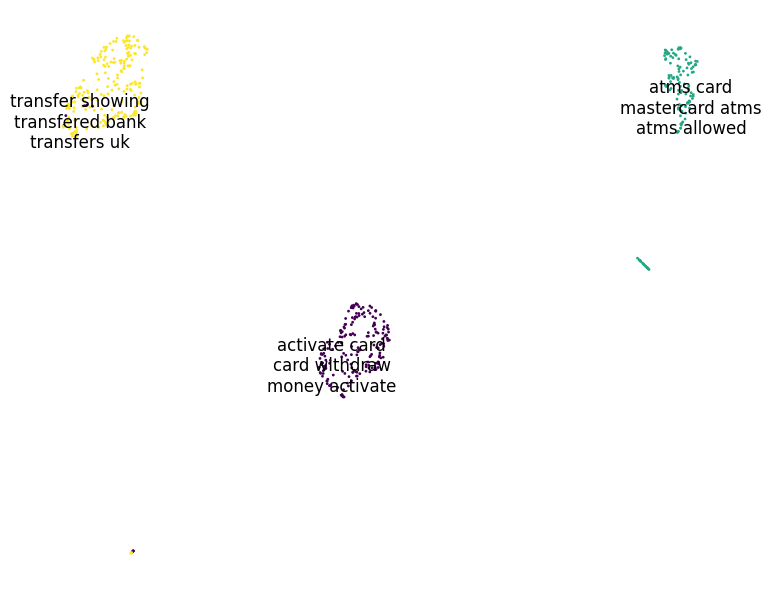

In [18]:
#umap_embeds = model.transform(base_embeds.to(device), batch_size=128)
new_centers = dim_reduction.transform(model.get_centers())
_, pred_clusters = model.transform_and_cluster(base_embeds.to(device))
plt.figure(figsize=(9, 9))
plt.scatter(*umap_features.T, c=base_clusters, s=1.0)
#plt.scatter(*new_umap_embeds.T, c=base_clusters, s=1.0)
for i, (x, y) in enumerate(new_centers):
    plt.text(x, y, "\n".join(topics[i]), 
             horizontalalignment='center', 
             verticalalignment='center', 
             fontsize=12)# backgroundcolor='white')
plt.gca().set_aspect("equal")
plt.axis("off")
#plt.title("Parametric UMAP for Banking77")
#plt.legend()
plt.show()